In [ ]:
!pip install keras_unet_collection

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.7 MB/s eta 0:00:00


In [ ]:
import zipfile
import os
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
import warnings
warnings.filterwarnings('ignore')
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import re
from keras_unet_collection import models, losses
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Accuracy
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arjundaiict/img-haze")

print("Path to dataset files:", path)

100%|██████████| 23.9G/23.9G [05:25<00:00, 79.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arjundaiict/img-haze/versions/1


In [ ]:
data_path = "/root/.cache/kagglehub/datasets/arjundaiict/img-haze/versions/1/ALL-mrg/ALL-mrg"

In [ ]:
# for root, dirs, files in os.walk(data_path):
#     for file in files:
#         print(os.path.join(root, file))

In [ ]:
haze_files = glob(pathname = data_path+'/hazy/*')
haze_files[:1]

['/root/.cache/kagglehub/datasets/arjundaiict/img-haze/versions/1/ALL-mrg/ALL-mrg/hazy/frm_1 (10974).jpg']

In [ ]:
clear_files = []

for path in haze_files:
    filename = os.path.basename(path)
    new_filename = re.sub(r'frm_\d+ ', '', filename)
    new_directory = os.path.dirname(path).replace("hazy", "clear") + "/" + "/"
    new_path = os.path.join(new_directory, new_filename)
    clear_files.append(new_path)

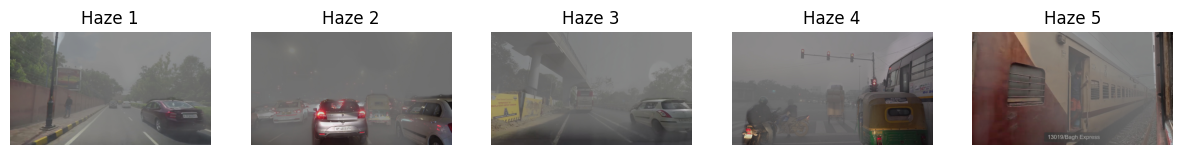

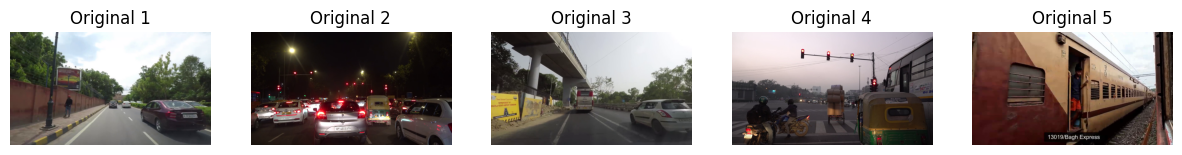

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    haze_img = cv2.imread(haze_files[i])
    haze_img_rgb = cv2.cvtColor(haze_img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(haze_img_rgb)
    axes[i].axis('off')
    axes[i].set_title(f'Haze {i+1}')

plt.show()

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    img = cv2.imread(clear_files[i])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img_rgb)
    axes[i].axis('off')
    axes[i].set_title(f'Original {i+1}')

plt.show()

In [ ]:
df = pd.DataFrame( data = {
    'haze_train': haze_files,
    'images': clear_files
})
# df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.shape

(65340, 2)

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.3)

print(df_train.shape)
print(df_test.shape)

(45738, 2)
(19602, 2)


In [ ]:
def center_crop(image, crop_size=(512, 512)):
    height, width = image.shape[:2]
    left = (width - crop_size[0]) // 2
    top = (height - crop_size[1]) // 2
    right = (width + crop_size[0]) // 2
    bottom = (height + crop_size[1]) // 2
    cropped_image = image[top:bottom, left:right]
    return cropped_image

In [ ]:
def load_and_preprocess_image(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_crop = center_crop(img_rgb)
    img_scaled = image_crop.astype(np.float32) / 255.0
    return img_scaled

In [ ]:
def generate_data_generator(dataframe, batch_size=8):
    num_samples = len(dataframe)
    while True:
        batch_haze = []
        batch_images = []
        while len(batch_haze) < batch_size:
            idx = np.random.randint(0, num_samples)
            haze_path = dataframe.iloc[idx]['haze_train']
            haze_img = cv2.imread(haze_path)
            original_path = dataframe.iloc[idx]['images']
            original_img = cv2.imread(original_path)

            if haze_img is None or original_img is None:
                continue

            if haze_img.shape[0] >= 512 and haze_img.shape[1] >= 512:
                haze_img_crop = load_and_preprocess_image(haze_img)
                original_img_crop = load_and_preprocess_image(original_img)

                batch_haze.append(haze_img_crop)
                batch_images.append(original_img_crop)

        yield np.array(batch_haze), np.array(batch_images)

In [ ]:
batch_size = 8
train_generator = generate_data_generator(df_train, batch_size=batch_size)
test_generator = generate_data_generator(df_test, batch_size=batch_size)

In [ ]:
def ssim_loss(y_true, y_pred):
    return 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def ssim(y_true, y_pred):
     return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model

def custom_unet(input_shape, filter_num, n_labels, stack_num_down, stack_num_up, activation='ReLU', output_activation='Sigmoid', pool=False, unpool=False, batch_norm=True):
    inputs = Input(shape=input_shape)

    encoder_blocks = []
    decoder_blocks = []

    x = inputs
    for i in range(stack_num_down):
        x = Conv2D(filter_num[i], (3, 3), activation=None, padding='same')(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
        encoder_blocks.append(x)
        if pool:
            x = MaxPooling2D((2, 2))(x)

    x = Conv2D(filter_num[stack_num_down], (3, 3), activation=None, padding='same')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)

    for i in range(stack_num_up):
        if unpool:
            x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, encoder_blocks[-(i + 1)]])
        x = Conv2D(filter_num[stack_num_down + i], (3, 3), activation=None, padding='same')(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
        x = Conv2D(filter_num[stack_num_down + i], (3, 3), activation=None, padding='same')(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
        decoder_blocks.append(x)

    outputs = Conv2D(n_labels, (1, 1), activation=output_activation)(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
input_shape = (None, None, 3)
filter_num = [4, 8, 16, 32]
n_labels = 3
stack_num_down = 2
stack_num_up = 2
activation = 'relu'
output_activation = 'sigmoid'
pool = False
unpool = False
batch_norm = True

In [ ]:
model = custom_unet(input_shape, filter_num, n_labels, stack_num_down, stack_num_up, activation, output_activation, pool, unpool, batch_norm)

In [ ]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None, 4)  │            112 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, None, None, 4)  │             16 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, None, None, 4)  │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, None, None, 8)  │            296 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, None, None, 8)  │             32 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, None, None, 8)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, None, None, 16) │          1,168 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, None, None, 16) │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, None, None, 16) │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, None, 24) │              0 │ activation_2[0][0],    │
│                           │                        │                │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, None, None, 16) │          3,472 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, None, None, 16) │             64 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, None, None, 16) │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, None, None, 16) │          2,320 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, None, None, 16) │             64 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 23,003 (89.86 KB)

 Trainable params: 22,755 (88.89 KB)

 Non-trainable params: 248 (992.00 B)

In [ ]:
model.compile(optimizer='adam', loss=ssim_loss, metrics=[ssim])

In [ ]:
epochs=1

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(df_train) // batch_size,
    epochs=epochs,
    # callbacks=[checkpoint],
    validation_data=test_generator,
    validation_steps=len(df_test) // batch_size
)

5717/5717 ━━━━━━━━━━━━━━━━━━━━ 2631s 455ms/step - loss: 0.1525 - ssim: 0.8475 - val_loss: 0.1625 - val_ssim: 0.8375


In [ ]:
model_path = "/content/drive/MyDrive/Project CV/best_model_w_o_resize.h5"
model.save(model_path)

In [ ]:
model_path = "/content/drive/MyDrive/Project CV/best_model_w_o_resize.keras"
model.save(model_path)

In [ ]:
for i in range(10):
    img = cv2.imread(df_test['haze_train'].iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img2 = cv2.imread(df_test['images'].iloc[i])
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    h_img = img
    o_img = img2

    img = img.astype(np.float32) / 255.0
    img = img[np.newaxis, : ,:, :]
    pred_img = model.predict(img)
    plt.figure(figsize=(12, 6))

    # Plotting first row
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(h_img))
    plt.title("Original Haze Image")

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(o_img))
    plt.title("Original Clear Image")

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img))
    plt.title("Predicted Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
#     plt.savefig('Originals_vs_Predictions_{}.png'.format(i))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# import cv2
# import numpy as np
# from tqdm import tqdm  # For progress bar

# def preprocess_frame(frame):
#     """
#     Preprocess a video frame for haze removal.

#     Parameters:
#     - frame (np.array): Input video frame.

#     Returns:
#     - preprocessed_frame (np.array): Preprocessed frame ready for prediction.
#     """
#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
#     frame_scaled = frame_rgb.astype(np.float32) / 255.0  # Normalize to [0, 1]
#     return frame_scaled[np.newaxis, :, :, :]  # Add batch dimension

# def postprocess_frame(predicted_frame):
#     """
#     Postprocess the predicted frame.

#     Parameters:
#     - predicted_frame (np.array): Predicted frame from the model.

#     Returns:
#     - output_frame (np.array): Postprocessed frame in uint8 format.
#     """
#     predicted_frame = np.squeeze(predicted_frame)  # Remove batch dimension
#     predicted_frame = (predicted_frame - predicted_frame.min()) / (
#         predicted_frame.max() - predicted_frame.min()
#     )  # Normalize to [0, 1]
#     output_frame = (predicted_frame * 255).astype(np.uint8)  # Convert to uint8
#     return cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)  # Convert back to BGR

# def remove_haze_from_video(input_video_path, output_video_path, model):
#     """
#     Remove haze from a video using a trained model.

#     Parameters:
#     - input_video_path (str): Path to the input video.
#     - output_video_path (str): Path to save the output dehazed video.
#     - model (keras.Model): Trained haze removal model.
#     """
#     # Open the input video
#     cap = cv2.VideoCapture(input_video_path)
#     if not cap.isOpened():
#         raise ValueError(f"Unable to open video: {input_video_path}")

#     # Get video properties
#     frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#     frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#     fps = int(cap.get(cv2.CAP_PROP_FPS))
#     total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

#     # Define the codec and create VideoWriter object
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
#     out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

#     print(f"Processing video: {input_video_path}")
#     print(f"Saving to: {output_video_path}")

#     # Process each frame
#     for _ in tqdm(range(total_frames), desc="Processing Frames"):
#         ret, frame = cap.read()
#         if not ret:
#             break

#         # Preprocess the frame
#         preprocessed_frame = preprocess_frame(frame)

#         # Predict the dehazed frame
#         predicted_frame = model.predict(preprocessed_frame)

#         # Postprocess the frame
#         dehazed_frame = postprocess_frame(predicted_frame)

#         # Write the frame to the output video
#         out.write(dehazed_frame)

#     # Release resources
#     cap.release()
#     out.release()
#     print("Video processing complete!")

# # Paths to input and output videos
# input_video_path = "/content/drive/MyDrive/Project CV/lahore.mp4"
# output_video_path = "/content/drive/MyDrive/Project CV/clear_lahore.mp4"

# # Call the haze removal function
# remove_haze_from_video(input_video_path, output_video_path, model)
